# Overview
Objective: Create a chat agent that responds in a specific format using OpenAI function calling. This agent is designed to act like a weatherman, returning a structured response with the temperature and other weather notes.

# 1. Set Up the State

In [1]:
!pip install langgraph

# Respond in a format
In this example we will build a chat executor that responds in a specific format. We will do this by using OpenAI function calling. This is useful when you want to enforce that an agent's response is in a specific format. In this example, we will ask it respond as if a weatherman, so to return the temperature and then any other additional info.

This examples builds off the base chat executor. It is highly recommended you learn about that executor before going through this notebook. You can find documentation for that example here.

Any modifications of that example are called below with MODIFICATION, so if you are looking for the differences you can just search for that.



# 1. Install Required Packages and Set API Keys

In [2]:
# Install the necessary packages required for running the notebook
%%capture --no-stderr
%pip install --quiet -U langgraph langchain langchain_openai tavily-python

# Import modules to set environment variables for API keys
import getpass
import os

# Set API keys for OpenAI (the LLM we will use) and Tavily (the search tool we will use)
os.environ["OPENAI_API_KEY"] = "open api key"
os.environ["TAVILY_API_KEY"] = "tavily api key"

# Optionally, set API key for LangSmith tracing, which provides observability for debugging
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = "lang smith api key"


# Set up the tools
We will first define the tools we want to use. For this simple example, we will use a built-in search tool via Tavily. However, it is really easy to create your own tools - see documentation here on how to do that.

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=1)]

We can now wrap these tools in a simple ToolExecutor. This is a real simple class that takes in a ToolInvocation and calls that tool, returning the output. A ToolInvocation is any class with tool and tool_input attribute.

In [4]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

<ipython-input-4-fdad03f5602e>:3: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


# Set up the model
Now we need to load the chat model we want to use. Importantly, this should satisfy two criteria:

1. It should work with messages. We will represent all agent state in the form of messages, so it needs to be able to work well with them.
2. It should work with OpenAI function calling. This means it should either be an OpenAI model or a model that exposes a similar interface.

Note: these model requirements are not requirements for using LangGraph - they are just requirements for this one example.

In [5]:
from langchain_openai import ChatOpenAI

# We will set streaming=True so that we can stream tokens
# See the streaming section for more information on this.
model = ChatOpenAI(temperature=0, streaming=True)

After we've done this, we should make sure the model knows that it has these tools available to call. We can do this by converting the LangChain tools into the format for OpenAI function calling, and then bind them to the model class.

**MODIFICATION**

We also want to define a response schema for the language model and bind it to the model as a function as well

In [6]:
from langchain_core.pydantic_v1 import BaseModel, Field


class Response(BaseModel):
    """Final response to the user"""

    temperature: float = Field(description="the temperature")
    other_notes: str = Field(description="any other notes about the weather")


model = model.bind_tools(tools + [Response])

# 6. Define the Agent State

The main type of graph in langgraph is the StateGraph. This graph is parameterized by a state object that it passes around to each node. Each node then returns operations to update that state. These operations can either SET specific attributes on the state (e.g. overwrite the existing values) or ADD to the existing attribute. Whether to set or add is denoted by annotating the state object you construct the graph with.

For this example, the state we will track will just be a list of messages. We want each node to just add messages to that list. Therefore, we will use a TypedDict with one key (messages) and annotate it so that the messages attribute is always added to.

In [7]:
# Import necessary modules and types for defining the agent's state
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage

# Define the AgentState class to manage agent's conversation state
class AgentState(TypedDict):
    # Messages is a list that accumulates BaseMessages, updated using the 'add' operation
    messages: Annotated[Sequence[BaseMessage], operator.add]


# 7. Define Nodes and Conditional Logic
We now need to define a few different nodes in our graph. In langgraph, a node can be either a function or a runnable. There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges. Some of these edges may be conditional. The reason they are conditional is that based on the output of a node, one of several paths may be taken. The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either: a. If the agent said to take an action, then the function to invoke tools should be called b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next
Let's define the nodes, as well as a function to decide how what conditional edge to take.

**MODIFICATION**

We will change the should_continue function to check what function was called. If the function Response was called - that is the function that is NOT a tool, but rather the formatted response, so we should NOT continue in that case.

In [8]:
# Import additional types and functions required for defining graph behavior
from typing import Literal
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolInvocation

# Define a function to determine whether to continue or end the process
def should_continue(state) -> Literal["continue", "end"]:
    messages = state["messages"]
    last_message = messages[-1]
    # Check if there was no function call; if so, end the process
    if not last_message.tool_calls:
        return "end"
    # Check if the function call is of type 'Response'; if so, end the process
    if last_message.tool_calls[0]["name"] == "Response":
        return "end"
    # Otherwise, continue the process
    return "continue"

# Define the function to call the language model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # Return the model's response to be added to the conversation state
    return {"messages": [response]}

# Define the function to execute tools based on tool calls
def call_tool(state):
    messages = state["messages"]
    last_message = messages[-1]
    # Prepare tool invocations based on the tool calls in the last message
    tool_invocations = [ToolInvocation(tool=tc["name"], tool_input=tc["args"]) for tc in last_message.tool_calls]
    # Execute tools and obtain responses
    responses = tool_executor.batch(tool_invocations, return_exceptions=True)
    # Create tool messages based on responses and tool calls
    tool_messages = [ToolMessage(content=str(response), name=tc["name"], tool_call_id=tc["id"]) for tc, response in zip(last_message.tool_calls, responses)]
    # Return tool messages to be added to the conversation state
    return {"messages": tool_messages}


# 8. Define and Compile the StateGraph

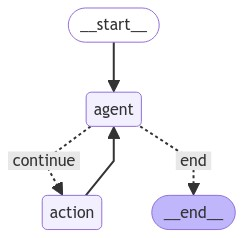

In [9]:
# Import required modules for defining and managing the state graph
from langgraph.graph import END, StateGraph, START

# Create a new StateGraph with the defined AgentState
workflow = StateGraph(AgentState)

# Add nodes to the graph: 'agent' node for calling the model and 'action' node for tool execution
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Define the entry point for the graph as the 'agent' node
workflow.add_edge(START, "agent")

# Add a conditional edge to decide the next step based on `should_continue` function
workflow.add_conditional_edges("agent", should_continue, {"continue": "action", "end": END})

# Add a normal edge from the 'action' node back to the 'agent' node
workflow.add_edge("action", "agent")

# Compile the workflow into a runnable application
app = workflow.compile()

# Optionally, visualize the graph structure (requires additional dependencies)
from IPython.display import Image, display
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass


# 9. Use the Compiled Application

In [10]:
# Import necessary module for creating messages
from langchain_core.messages import HumanMessage

# Define input messages to start the conversation with the agent
inputs = {"messages": [HumanMessage(content="what is the weather in pakistan")]}

# Stream the output of the compiled application step-by-step
for output in app.stream(inputs):
    # Print each output message from the different nodes
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value["messages"][-1])
    print("\n---\n")


Output from node 'agent':
---
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_q897gLNQSbLkukoI6ncQvYxY', 'function': {'arguments': '{"query":"weather in Pakistan"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'} id='run-21b95faf-4f95-4560-b117-eb7c723a1030-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Pakistan'}, 'id': 'call_q897gLNQSbLkukoI6ncQvYxY', 'type': 'tool_call'}]

---



<ipython-input-8-d6bdc5b1ea78>:31: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_invocations = [ToolInvocation(tool=tc["name"], tool_input=tc["args"]) for tc in last_message.tool_calls]


Output from node 'action':
---
content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Islamabad\', \'region\': \'Islamabad\', \'country\': \'Pakistan\', \'lat\': 33.7, \'lon\': 73.17, \'tz_id\': \'Asia/Karachi\', \'localtime_epoch\': 1725108657, \'localtime\': \'2024-08-31 17:50\'}, \'current\': {\'last_updated_epoch\': 1725108300, \'last_updated\': \'2024-08-31 17:45\', \'temp_c\': 31.6, \'temp_f\': 88.9, \'is_day\': 1, \'condition\': {\'text\': \'Sunny\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/113.png\', \'code\': 1000}, \'wind_mph\': 3.1, \'wind_kph\': 5.0, \'wind_degree\': 205, \'wind_dir\': \'SSW\', \'pressure_mb\': 1004.0, \'pressure_in\': 29.64, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 55, \'cloud\': 11, \'feelslike_c\': 35.1, \'feelslike_f\': 95.2, \'windchill_c\': 31.6, \'windchill_f\': 88.9, \'heatindex_c\': 35.1, \'heatindex_f\': 95.2, \'dewpoint_c\': 21.3, \'dewpoint_f\': 70.4, \'vis_km\': 10.0, \'vis_miles\':